### Reason for analysis

For several years now, _I’ve heard acquaintances lament: We don’t have spring anymore. We skip spring and go straight to summer. I miss spring-like temperatures._ To see if data supports this belief, this notebook analyzes publicly available NOAA weather station data collected from 1910 - 2023 at the Knoxville, TN airport.

### Terms/definitions for this analysis
* Spring is March 20 to June 21 (94 days)
* A spring-like temperature is 78℉ or below
* A summer-like temperature is 79℉ or above
* Middle-spring is the timeframe that my acquaintances are complaining about April 1 - May 31.
* The Historical years are the sixteen year span of 1992 - 2007
* The Recent years are the sixteen year span of 2008 - 2023

### Notebook assumes: 
  1. [data processing steps](https://github.com/h-fuzzy-logic/technical-writing/blob/main/noaa-glue-athena.md) completed 
  1. dataset saved to personal S3 bucket as Parquet
  1. credentials to access S3

In [1]:
import awswrangler as wr
import pandas as pd
import seaborn as sns
import  matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import datetime as dt

In [2]:
personal_s3_path = 's3://<<your_bucket>>/<<your_folder>>/'
s3_path = personal_s3_path
df = wr.s3.read_parquet(
    path=s3_path,
    use_threads =True)
df.head()

,id,date,data_value,m_flag,q_flag,s_flag,obs_time,data_value_f
0,USW00013891,19110529,333,<NA>,<NA>,0,<NA>,91.94
1,USW00013891,19110530,322,<NA>,<NA>,0,<NA>,89.96
2,USW00013891,19110531,317,<NA>,<NA>,0,<NA>,89.06
3,USW00013891,19110601,283,<NA>,<NA>,0,<NA>,82.94
4,USW00013891,19110602,306,<NA>,<NA>,0,<NA>,87.08


### EDA
Initial exploration of the data.  Includes processing on the date string easier exploration. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41508 entries, 0 to 41507
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            41508 non-null  string 
 1   date          41508 non-null  string 
 2   data_value    41508 non-null  Int64  
 3   m_flag        0 non-null      string 
 4   q_flag        15 non-null     string 
 5   s_flag        41508 non-null  string 
 6   obs_time      15279 non-null  string 
 7   data_value_f  41508 non-null  float64
dtypes: Int64(1), float64(1), string(6)
memory usage: 2.6 MB


In [4]:
df.data_value_f.describe()

count    41508.000000
mean        69.547285
std         17.008004
min          6.980000
25%         57.020000
50%         71.960000
75%         84.020000
max        105.080000
Name: data_value_f, dtype: float64

In [5]:
df['dt'] = pd.to_datetime(df['date'])
df['year'] = df['dt'].dt.year
df['day_of_year'] = df['dt'].dt.dayofyear
df.head(10)


,id,date,data_value,m_flag,q_flag,s_flag,obs_time,data_value_f,dt,year,day_of_year
0,USW00013891,19110529,333,<NA>,<NA>,0,<NA>,91.94,1911-05-29,1911,149
1,USW00013891,19110530,322,<NA>,<NA>,0,<NA>,89.96,1911-05-30,1911,150
2,USW00013891,19110531,317,<NA>,<NA>,0,<NA>,89.06,1911-05-31,1911,151
3,USW00013891,19110601,283,<NA>,<NA>,0,<NA>,82.94,1911-06-01,1911,152
4,USW00013891,19110602,306,<NA>,<NA>,0,<NA>,87.08,1911-06-02,1911,153
5,USW00013891,19110603,333,<NA>,<NA>,0,<NA>,91.94,1911-06-03,1911,154
6,USW00013891,19110604,356,<NA>,<NA>,0,<NA>,96.08,1911-06-04,1911,155
7,USW00013891,19110605,256,<NA>,<NA>,0,<NA>,78.08,1911-06-05,1911,156
8,USW00013891,19110606,294,<NA>,<NA>,0,<NA>,84.92,1911-06-06,1911,157
9,USW00013891,19110607,311,<NA>,<NA>,0,<NA>,87.98,1911-06-07,1911,158


In [6]:
df.agg(
    {
        "data_value": ["min", "max", "median", "mean"],
        "data_value_f": ["min", "max", "median", "mean"],
        "dt": ["min", "max", "median", "mean"],
        "year": ["min", "max", "median", "mean"],
        "day_of_year": ["min", "max", "median", "mean"],
    }
)

,data_value,data_value_f,dt,year,day_of_year
min,-139.00000,6.980000,1910-01-01 00:00:00.000000000,1910.000000,1.000000
max,406.00000,105.080000,2023-09-04 00:00:00.000000000,2023.000000,366.000000
median,222.00000,71.960000,1966-11-08 12:00:00.000000000,1966.000000,183.000000
mean,208.59603,69.547285,1966-11-05 09:07:55.628794448,1966.346969,182.774863


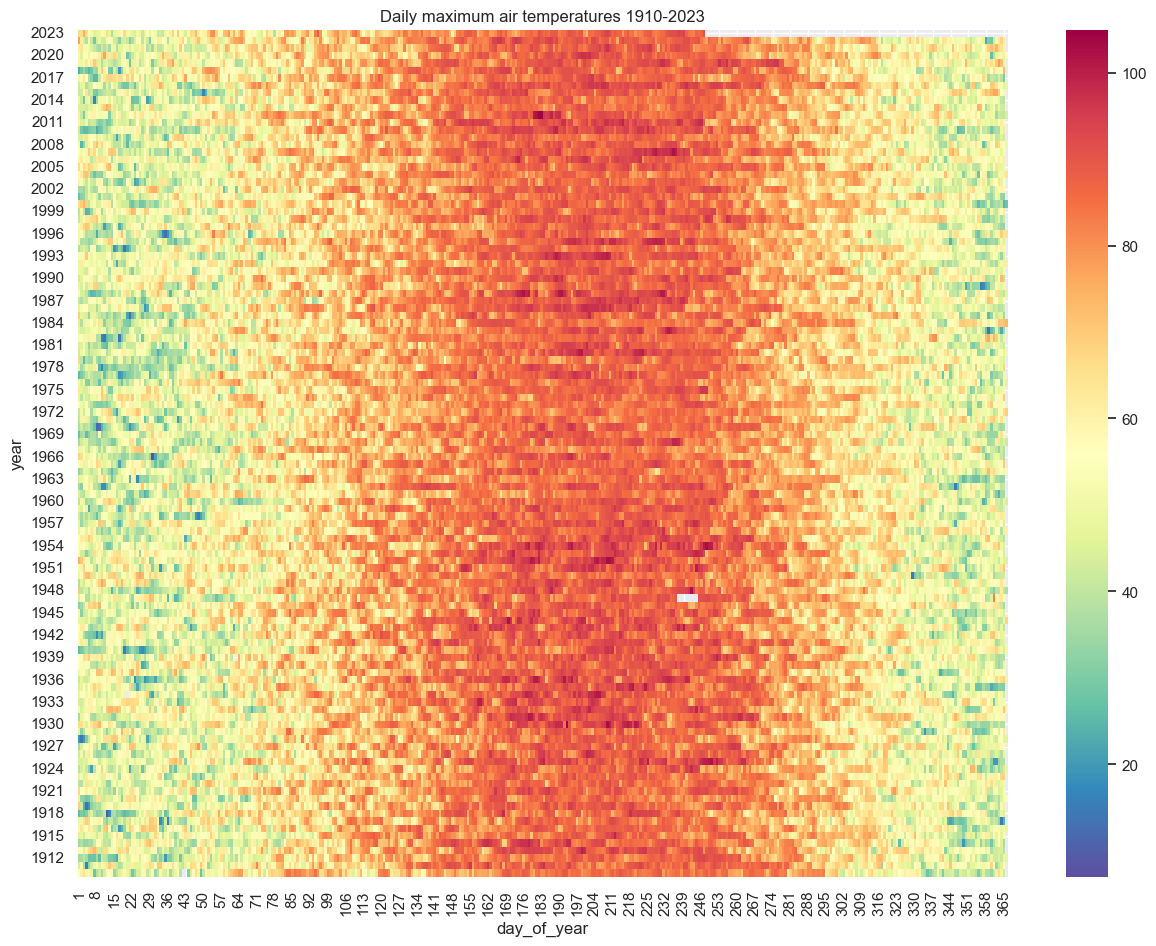

In [7]:
VMIN, VMAX = 7, 105
title = 'Daily maximum air temperatures 1910-2023'
sns.set(rc={'figure.figsize':(15, 11)})
sns.heatmap(df.pivot(index='year', columns='day_of_year', values='data_value_f').sort_values(by='year', ascending=False), cmap='Spectral_r', vmin=VMIN, vmax=VMAX).set(title=title)
plt.show()

### EDA Findings
1. Leap years are present
1. Some data is missing around 1947 (white area in heat map)
1. 2023 data through August
1. min/max temperatures seem reasonable
1. Need to specify min/max for each heatmap so that the colors will be consistent
1. With plot, can see warmer temperatures in the middle of the year 


### Focus on Spring 
Reduce data to the observations in middle-spring

In [8]:
#Defining spring as March 20 to June 21 (94 days), days 79-172
SPRING_START = dt.date(2023, 3, 20).timetuple().tm_yday
SPRING_END = dt.date(2023, 6, 21).timetuple().tm_yday

df_spring = df.loc[(df['day_of_year'] >= SPRING_START) & (df['day_of_year'] <= SPRING_END)]
df_spring.head()

,id,date,data_value,m_flag,q_flag,s_flag,obs_time,data_value_f,dt,year,day_of_year
0,USW00013891,19110529,333,<NA>,<NA>,0,<NA>,91.94,1911-05-29,1911,149
1,USW00013891,19110530,322,<NA>,<NA>,0,<NA>,89.96,1911-05-30,1911,150
2,USW00013891,19110531,317,<NA>,<NA>,0,<NA>,89.06,1911-05-31,1911,151
3,USW00013891,19110601,283,<NA>,<NA>,0,<NA>,82.94,1911-06-01,1911,152
4,USW00013891,19110602,306,<NA>,<NA>,0,<NA>,87.08,1911-06-02,1911,153


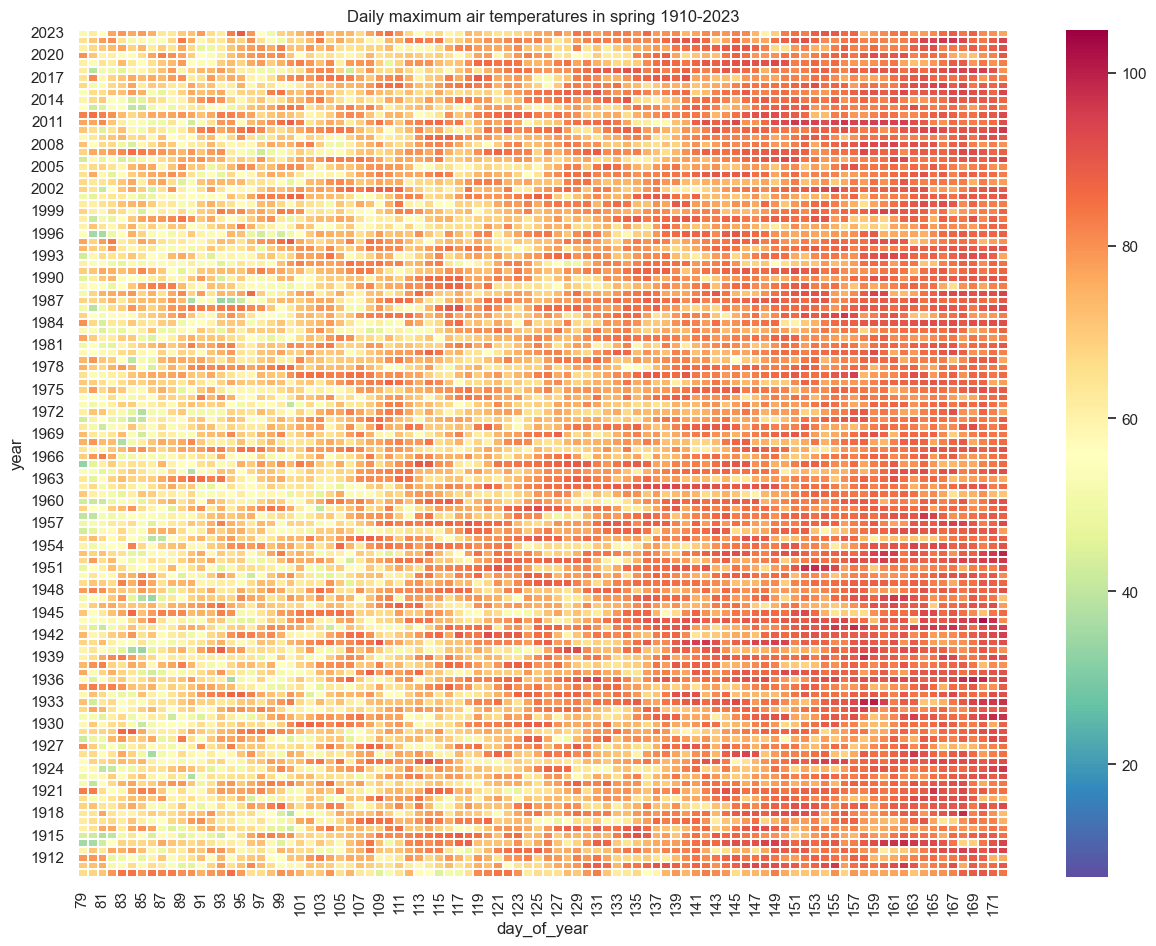

In [9]:
title = 'Daily maximum air temperatures in spring 1910-2023'
df_sorted = df_spring.pivot(index='year', columns='day_of_year', values='data_value_f').sort_values(by='year', ascending=False)
sns.heatmap(df_sorted, cmap='Spectral_r', linewidths=0.01, linecolor='white', vmin=VMIN, vmax=VMAX).set(title=title)
plt.show()

In [10]:
SPRING_MID_START = dt.date(2023, 4, 1).timetuple().tm_yday
SPRING_MID_END = dt.date(2023, 5, 31).timetuple().tm_yday

def is_middle_spring(day_of_year):
    if day_of_year >= SPRING_MID_START and day_of_year <= SPRING_MID_END:
        return True
    else: 
        return False 

df['is_mid_spring'] = df.apply(lambda row: is_middle_spring(row['day_of_year']), axis=1)

In [11]:
FIRST_YEAR_IN_COMPARISON = 1992
df_filtered = df.loc[(df['year'] >= FIRST_YEAR_IN_COMPARISON) & (df['is_mid_spring'])]
df_filtered.head()

,id,date,data_value,m_flag,q_flag,s_flag,obs_time,data_value_f,dt,year,day_of_year,is_mid_spring
695,USW00013891,20000331,211,<NA>,<NA>,0,2400,69.98,2000-03-31,2000,91,True
696,USW00013891,20000401,239,<NA>,<NA>,0,2400,75.02,2000-04-01,2000,92,True
697,USW00013891,20000402,206,<NA>,<NA>,0,2400,69.08,2000-04-02,2000,93,True
698,USW00013891,20000403,183,<NA>,<NA>,0,2400,64.94,2000-04-03,2000,94,True
699,USW00013891,20000404,128,<NA>,<NA>,0,2400,55.04,2000-04-04,2000,95,True


In [12]:
SUMMER_LIKE_TEMP_MIN = 78
def is_summer_like(temp):
    if temp >= SUMMER_LIKE_TEMP_MIN: 
        return True
    else: return False

df_filtered['is_summer_like'] = df_filtered.apply(lambda row: is_summer_like(row['data_value_f']), axis=1)
df.head()

/var/folders/5c/2g5pnc294tzdprzlrp4btz_m0000gn/T/ipykernel_6426/604651632.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_summer_like'] = df_filtered.apply(lambda row: is_summer_like(row['data_value_f']), axis=1)


,id,date,data_value,m_flag,q_flag,s_flag,obs_time,data_value_f,dt,year,day_of_year,is_mid_spring
0,USW00013891,19110529,333,<NA>,<NA>,0,<NA>,91.94,1911-05-29,1911,149,True
1,USW00013891,19110530,322,<NA>,<NA>,0,<NA>,89.96,1911-05-30,1911,150,True
2,USW00013891,19110531,317,<NA>,<NA>,0,<NA>,89.06,1911-05-31,1911,151,True
3,USW00013891,19110601,283,<NA>,<NA>,0,<NA>,82.94,1911-06-01,1911,152,False
4,USW00013891,19110602,306,<NA>,<NA>,0,<NA>,87.08,1911-06-02,1911,153,False


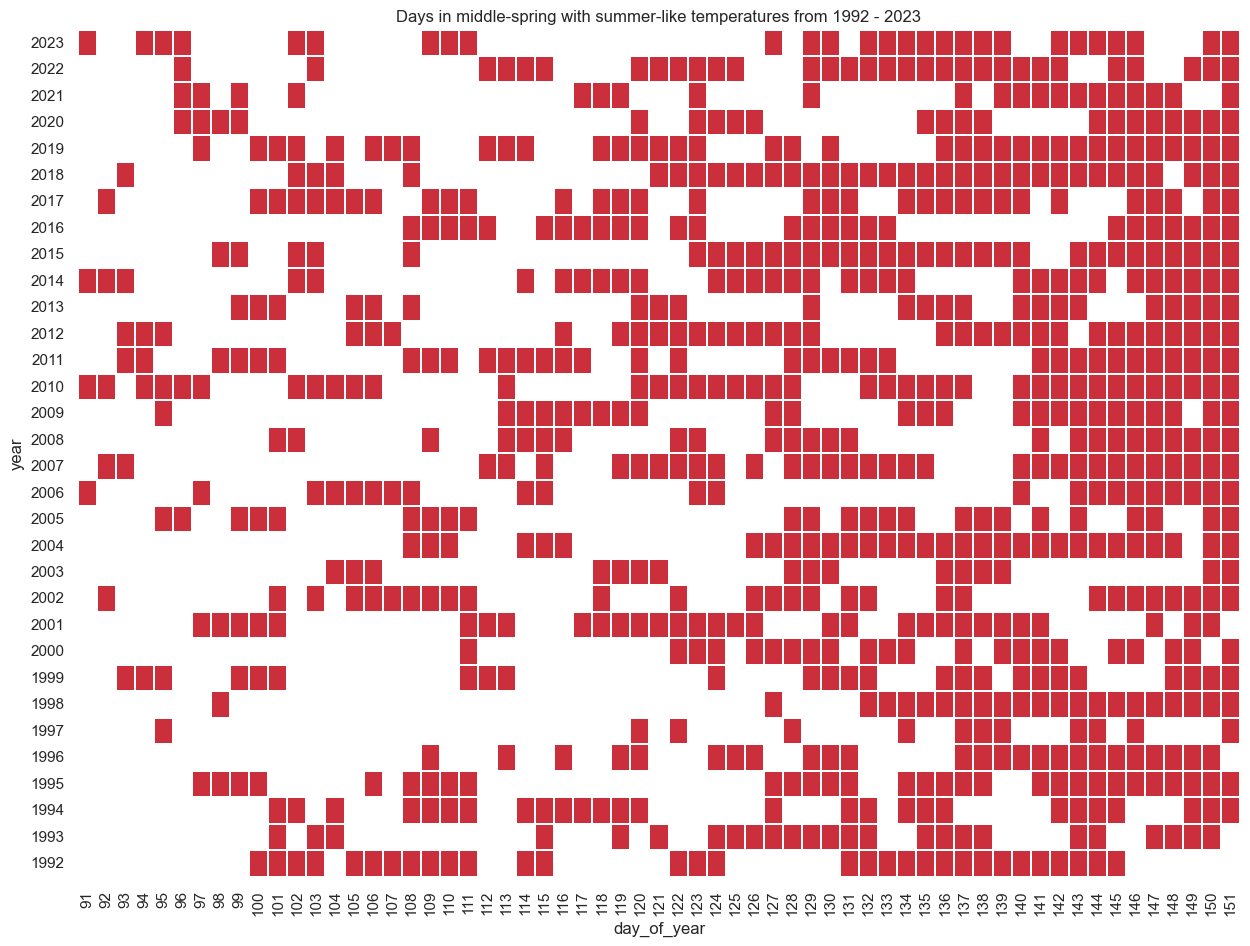

In [13]:
my_colors = ['white', '#CB2F3C'] 
my_cmap = ListedColormap(my_colors)
title = 'Days in middle-spring with summer-like temperatures from 1992 - 2023'
sns.heatmap(df_filtered.pivot(index='year', columns='day_of_year', values='is_summer_like').fillna(False).sort_values(by='year', ascending=False), cmap=my_cmap, cbar=False, linewidths=0.01, linecolor='white').set(title=title)
plt.show()

In [14]:
df_summer_like = df_filtered.loc[df_filtered.is_summer_like == True]
df_summer_like.head()

,id,date,data_value,m_flag,q_flag,s_flag,obs_time,data_value_f,dt,year,day_of_year,is_mid_spring,is_summer_like
715,USW00013891,20000420,289,<NA>,<NA>,0,2400,84.02,2000-04-20,2000,111,True,True
726,USW00013891,20000501,261,<NA>,<NA>,0,2400,78.98,2000-05-01,2000,122,True,True
727,USW00013891,20000502,256,<NA>,<NA>,0,2400,78.08,2000-05-02,2000,123,True,True
728,USW00013891,20000503,278,<NA>,<NA>,0,2400,82.04,2000-05-03,2000,124,True,True
730,USW00013891,20000505,278,<NA>,<NA>,0,2400,82.04,2000-05-05,2000,126,True,True


In [15]:
df_year = df_summer_like.groupby(['year']).size().to_frame('number_of_summer_like_days').reset_index()
df_year.head(10)

,year,number_of_summer_like_days
0,1992,31
1,1993,25
2,1994,27
3,1995,30
4,1996,25
5,1997,12
6,1998,22
7,1999,25
8,2000,22
9,2001,31


In [16]:
FIRST_YEAR_CONSIDERED_RECENT = 2008 
def timeframe(year):
    if year >= FIRST_YEAR_CONSIDERED_RECENT:
        return 'Recent'
    else:
        return 'Historical'

In [17]:
df_year['timeframe'] = df_year.apply(lambda row: timeframe(row['year']), axis=1)
df_year.head(10)

,year,number_of_summer_like_days,timeframe
0,1992,31,Historical
1,1993,25,Historical
2,1994,27,Historical
3,1995,30,Historical
4,1996,25,Historical
5,1997,12,Historical
6,1998,22,Historical
7,1999,25,Historical
8,2000,22,Historical
9,2001,31,Historical


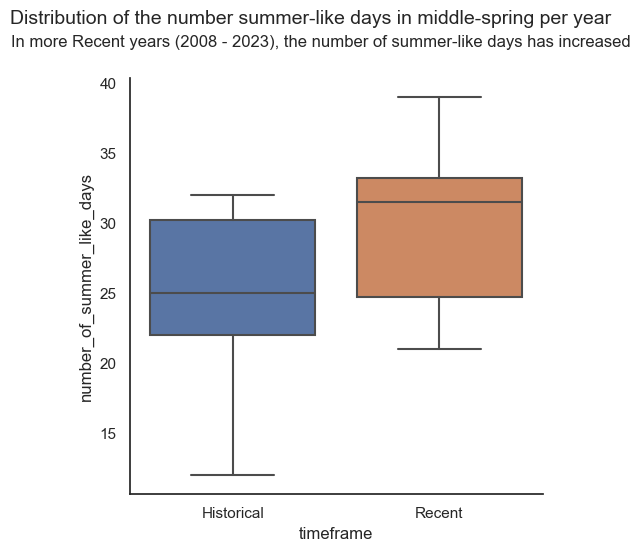

In [18]:
sns.set(rc={'figure.figsize':(15, 11)})
sns.set_theme(style='white')
title = "Distribution of the number summer-like days in middle-spring per year"
cp = sns.catplot(data=df_year, x="timeframe", y="number_of_summer_like_days", kind="box")
cp.fig.suptitle(title, x = 0.5, y = 1.1, fontsize = 14)
cp.fig.text(x=-0.10, y=1.025, s="In more Recent years (2008 - 2023), the number of summer-like days has increased")
plt.show()


### Analysis of Boxplots

The boxplots summarize the number of unexpected summer-like days in middle-spring per year for the two categories, Historical (1992 - 2007) and Recent (2008 - 2023).  

The Recent boxplot shows a trend towards more summer-like days.  The median number of summer-like days is 31 and the range is 22-39.  Historical is showing fewer summer-like days.  The median is 25 and the range is 11-32.  

This could explain the perception that there are more summer-like days in middle-spring nowadays.